In [1]:
import sys
import os
import vamb
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [18]:
PATH_VAMB = '/Users/nmb127/Documents/vamb'
PATH_VAMB_DATA = '/Users/nmb127/Documents/vamb_data'

In [2]:
def filterclusters(clusters, lengthof):
    filtered_bins = dict()
    for medoid, contigs in clusters.items():
        binsize = sum(lengthof[contig] for contig in contigs)
    
        if binsize >= 200000:
            filtered_bins[medoid] = contigs
    
    return filtered_bins

In [3]:
def dataset_info(contig_path, depths_path, reference_path, taxonomy_path):
    with vamb.vambtools.Reader(contig_path, 'rb') as filehandle:
        tnfs, CONTIGNAMES, LENGTHS = vamb.parsecontigs.read_contigs(filehandle)
    rpkms = vamb.vambtools.read_npz(depths_path)
    _, MASK = vamb.encode.make_dataloader(rpkms, tnfs)
    with open(reference_path) as reference_file:
        REFERENCE = vamb.benchmark.Reference.from_file(reference_file)
    with open(taxonomy_path) as taxonomy_file:
        REFERENCE.load_tax_file(taxonomy_file)
    return CONTIGNAMES, MASK, LENGTHS, REFERENCE

In [36]:
CAMI_DATASETS = dict()
for s in ['airways', 'gi', 'oral', 'skin', 'urog']:
    CAMI_DATASETS[s] = dataset_info(
        f'{PATH_VAMB_DATA}/vamb_on_{s}/contigs.fna', 
        f'{PATH_VAMB_DATA}/vamb_on_{s}/depths.npz', 
        f'{PATH_VAMB_DATA}/vamb_on_{s}/reference.tsv', 
        f'{PATH_VAMB_DATA}/vamb_on_{s}/taxonomy.tsv', 
    )

In [5]:
def make_clusters(latent_labels, contignames, mask, lengths):
    filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
    cluster_iterator = vamb.cluster.cluster(latent_labels, labels=filtered_labels)
    clusters = dict(cluster_iterator)

    medoid, contigs = next(iter(clusters.items()))
    print('First key:', medoid, '(of type:', type(medoid), ')')
    print('Type of values:', type(contigs))
    print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

    lengthof = dict(zip(contignames, lengths))
    filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
    print('Number of bins before splitting and filtering:', len(clusters))
    print('Number of bins after splitting and filtering:', len(filtered_bins))
    
    return filtered_bins

In [46]:
def save_clusters_one(filepath, cluster_path, keyword, indices=None):
    CONTIGNAMES, MASK, LENGTHS, _ = CAMI_DATASETS[keyword]
    print(filepath)
    latent_labels = np.load(f'{filepath}')
    if filepath.endswith('npz'):
        latent_labels = latent_labels['arr_0']
    print(latent_labels.shape)
    if indices:
        print(len(indices))
        contignames, mask, lengths = \
            np.array(CONTIGNAMES)[indices], np.array(MASK)[indices], np.array(LENGTHS)[indices]
    else:
        contignames, mask, lengths = CONTIGNAMES, MASK, LENGTHS
        
    filtered_bins = make_clusters(latent_labels, contignames, mask, lengths)
    
    with open(f'{PATH_VAMB}/{cluster_path}', 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)


def bin_saved_clusters(cluster_path, keyword):
    _, _, _, REFERENCE = CAMI_DATASETS[keyword]
    with open(f'{cluster_path}') as clusters_file:
        vamb_clusters = vamb.vambtools.read_clusters(clusters_file)
        vamb_clusters_clean = {k: [i.strip() for i in v] for k, v in vamb_clusters.items()}
        vamb_bins = vamb.benchmark.Binning(vamb_clusters_clean, REFERENCE)
    return vamb_bins

In [57]:
def save_clusters_both(filepath_vamb, filepath_both, indices_vamb, indices_both, cluster_path, keyword):
    CONTIGNAMES, MASK, LENGTHS, _ = CAMI_DATASETS[keyword]
    latent_vamb = np.load(f'{PATH_VAMB}/{filepath_vamb}')
    latent_both = np.load(f'{PATH_VAMB}/{filepath_both}')
    new_indices = [np.argwhere(indices_vamb == i)[0][0] for i in indices_both]
    print(latent_both.shape, len(new_indices), indices_both.shape)
    latent_vamb[new_indices] = latent_both
    contignames, mask, lengths = \
        np.array(CONTIGNAMES)[indices_vamb], np.array(MASK)[indices_vamb], np.array(LENGTHS)[indices_vamb]
        
    filtered_bins = make_clusters(latent_vamb, contignames, mask, lengths)

    with open(f'{PATH_VAMB}/{cluster_path}', 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)

In [45]:
for s in ['airways']:
    save_clusters_one(f'{PATH_VAMB_DATA}/vamb_on_{s}/result3/latent.npz', f'clusters_{s}_paper.tsv', s)
    vamb_gi = bin_saved_clusters(f'{PATH_VAMB}/clusters_{s}_paper.tsv', s)
    print(vamb_gi.counters[0][(0.9, 0.95)])

/Users/nmb127/Documents/vamb_data/vamb_on_airways/result3/latent.npz
(187685, 32)
First key: S4C262502 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'str'>
Number of bins before splitting and filtering: 65291
Number of bins after splitting and filtering: 488
76


In [44]:
for s in ['airways', 'gi', 'oral', 'skin', 'urog']:
    save_clusters_one(f'{PATH_VAMB_DATA}/vamb_on_{s}/result3/latent.npz', f'clusters_{s}_paper.tsv', s)
    vamb_gi = bin_saved_clusters(f'{PATH_VAMB}/clusters_{s}_paper.tsv', s)
    print(vamb_gi.counters[0][(0.9, 0.95)])

/Users/nmb127/Documents/vamb_data/vamb_on_airways/result3/latent.npz
(187685, 32)
First key: S4C262502 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'str'>
Number of bins before splitting and filtering: 65291
Number of bins after splitting and filtering: 488
76
/Users/nmb127/Documents/vamb_data/vamb_on_gi/result3/latent.npz
(81602, 32)
First key: S11C207557 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S11C207557 of type: <class 'str'>
Number of bins before splitting and filtering: 10889
Number of bins after splitting and filtering: 370
100
/Users/nmb127/Documents/vamb_data/vamb_on_oral/result3/latent.npz
(201563, 32)
First key: S15C210837 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S14C133658 of type: <class 'str'>
Number of bins before splitting and filtering: 61147
Number of bins after splitting and filtering: 702
135
/Users/nmb127/Documents/vamb_data/vam

In [42]:
for s in ['airways', 'gi', 'oral', 'skin', 'urog']:
    vamb_gi = bin_saved_clusters(f'{PATH_VAMB_DATA}/vamb_on_{s}/result3/clusters.tsv', s)
    print(s, vamb_gi.counters[0][(0.9, 0.95)])

airways 79
gi 100
oral 135
skin 97
urog 89


In [48]:
save_clusters_one(f'{PATH_VAMB}/latent_trained_vamb_gi.npy', 'clusters_gi.tsv', 'gi')
vamb_gi = bin_saved_clusters(f'{PATH_VAMB}/clusters_gi.tsv', 'gi')
vamb_gi.counters[0][(0.9, 0.95)]

/Users/nmb127/Documents/vamb/latent_trained_vamb_gi.npy
(81602, 32)
First key: S11C207557 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S11C207557 of type: <class 'str'>
Number of bins before splitting and filtering: 9189
Number of bins after splitting and filtering: 359


87

In [71]:
from collections import defaultdict

RESULTS = defaultdict(dict)

In [88]:
for s in ['airways']:
    with open(f'{PATH_VAMB}/indices_mmseq_{s}.pickle', 'rb') as fp:
        indices_mmseq = pickle.load(fp)
    with open(f'{PATH_VAMB}/indices_mmseq_genus_{s}.pickle', 'rb') as fp:
        indices_mmseq_genus = pickle.load(fp)
        
    for sp in ['species']:
        RESULTS[s][sp] = dict()
        for n in [100, 50]:
            with open(f'{PATH_VAMB}/indices_{s}_{sp}_{n}.pickle', 'rb') as fp:
                indices_x, indices_y, indices_sup = pickle.load(fp)
                
#             save_clusters_both(
#                 f'latent_trained_semisupervised_{s}_{sp}_{n}_vamb.npy',
#                 f'latent_trained_semisupervised_{s}_{sp}_{n}_both.npy',
#                 np.array(indices_x),
#                 np.array(indices_sup),
#                 f'clusters_{s}_{n}_{sp}.tsv',
#                 s,
#             )
            RESULTS[s]['sup_species'] = len(np.array(indices_mmseq))*1.0/len(indices_x)
            RESULTS[s]['sup_genus'] = len(np.array(indices_mmseq_genus))*1.0/len(indices_x)
            RESULTS[s][sp][n] = bin_saved_clusters(f'{PATH_VAMB}/clusters_{s}_{n}_{sp}.tsv', s).counters[0][(0.9, 0.95)]
    RESULTS[s]['Vamb'] = bin_saved_clusters(f'{PATH_VAMB}/clusters_{s}.tsv', s).counters[0][(0.9, 0.95)]
    RESULTS[s]['mmseq_species'] = bin_saved_clusters(f'{PATH_VAMB}/clusters_mmseq_{s}.tsv', s).counters[0][(0.9, 0.95)]
    RESULTS[s]['mmseq_genus'] = bin_saved_clusters(f'{PATH_VAMB}/clusters_mmseq_genus_{s}.tsv', s).counters[0][(0.9, 0.95)]



In [89]:
RESULTS

defaultdict(dict,
            {'gi': {'species': {100: 145, 50: 99},
              'Vamb': 87,
              'mmseq_species': 125,
              'mmseq_genus': 127,
              'sup_species': 0.7487193941324968,
              'sup_genus': 0.9004313619764222},
             'oral': {'species': {100: 205, 50: 133},
              'sup_species': 0.6758333622738301,
              'sup_genus': 0.9393787550294449,
              'Vamb': 138,
              'mmseq_species': 154,
              'mmseq_genus': 164},
             'skin': {'species': {100: 223, 50: 98},
              'sup_species': 0.696458859176551,
              'sup_genus': 0.9313217614286453,
              'Vamb': 98,
              'mmseq_species': 133,
              'mmseq_genus': 151},
             'urog': {'species': {100: 132, 50: 80},
              'sup_species': 0.7123022056022991,
              'sup_genus': 0.9141303971469132,
              'Vamb': 86,
              'mmseq_species': 99,
              'mmseq_genus': 103},


In [90]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})


def plot_dataset(dataset):
    results = RESULTS[dataset]
    plt.figure(figsize=(12, 10))
    
    vamb, mmseq_species, mmseq_genus, sup_species, sup_genus = \
        results['Vamb'], results['mmseq_species'], results['mmseq_genus'], results['sup_species'], results['sup_genus']

    plt.axhline(y=vamb, color='crimson', label='Vamb')
    plt.text(87 + 1, vamb + 1, f'{vamb} strains')
    
    sups = [50, 100]

#     plt.plot(sups, [results['genus'][k] for k in sups], 'o--', label='Semisupervised, ground truth Vamb+Genus')
    plt.plot(sups, [results['species'][k] for k in sups], 'o--', label='Semisupervised, ground truth Vamb+Species')

    plt.scatter([sup_species*100], [mmseq_species], 
                s=[200], marker='X', label='mmseq_species', color='darkgreen')
    plt.text(sup_species*100 + 1, mmseq_species + 1, f'{mmseq_species} strains')

    plt.scatter([sup_genus*100], [mmseq_genus], 
                s=[200], marker='X', label='mmseq_genus', color='purple')
    plt.text(sup_genus*100 + 1, mmseq_genus + 1, f'{mmseq_genus} strains')

    plt.title(dataset)
    plt.ylabel(f'# of NC strains (recall > 0.9, precision > 0.95)')
    plt.xlabel('Supervision level, %')
    plt.legend()
    plt.savefig(f'/Users/nmb127/Downloads/mmseq_{dataset}.png')
    plt.show()

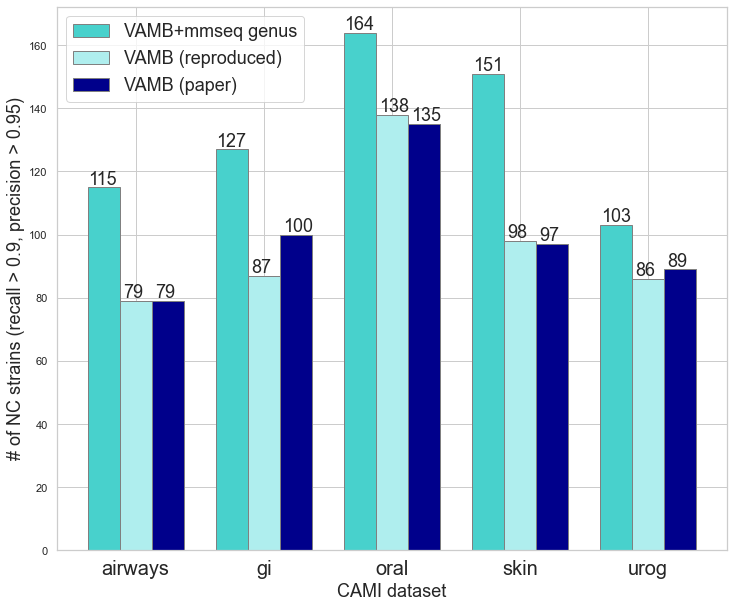

In [128]:
import matplotlib

barWidth = 0.25
matplotlib.rcParams.update({'font.size': 18})
# fig = plt.subplots(figsize =(12, 8))
plt.figure(figsize=(12, 10))

keys = ['airways', 'gi', 'oral', 'skin', 'urog']

# set height of bar
vamb_paper = [79, 100, 135, 97, 89]
vamb_repr = [RESULTS[k]['Vamb'] for k in keys]
vamb_genus = [RESULTS[k]['mmseq_genus'] for k in keys]
 
# Set position of bar on X axis
br1 = np.arange(len(keys))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, vamb_genus, color ='mediumturquoise', width = barWidth,
        edgecolor ='grey', label ='VAMB+mmseq genus')
plt.bar(br2, vamb_repr, color ='paleturquoise', width = barWidth,
        edgecolor ='grey', label ='VAMB (reproduced)')
plt.bar(br3, vamb_paper, color ='darkblue', width = barWidth,
        edgecolor ='grey', label ='VAMB (paper)')

for x, y in zip(br1, vamb_genus):
    plt.text(x-0.12, y+1, y)
for x, y in zip(br2, vamb_repr):
    plt.text(x-0.1, y+1, y)
for x, y in zip(br3, vamb_paper):
    plt.text(x-0.1, y+1, y)

plt.ylabel(f'# of NC strains (recall > 0.9, precision > 0.95)', fontsize=18)
plt.xlabel('CAMI dataset', fontsize=18)
plt.xticks([r + barWidth for r in range(len(keys))],
        keys, fontsize=20)
 
plt.legend(fontsize=18)
plt.savefig(f'/Users/nmb127/Downloads/cami_all_datasets.png')
plt.show()

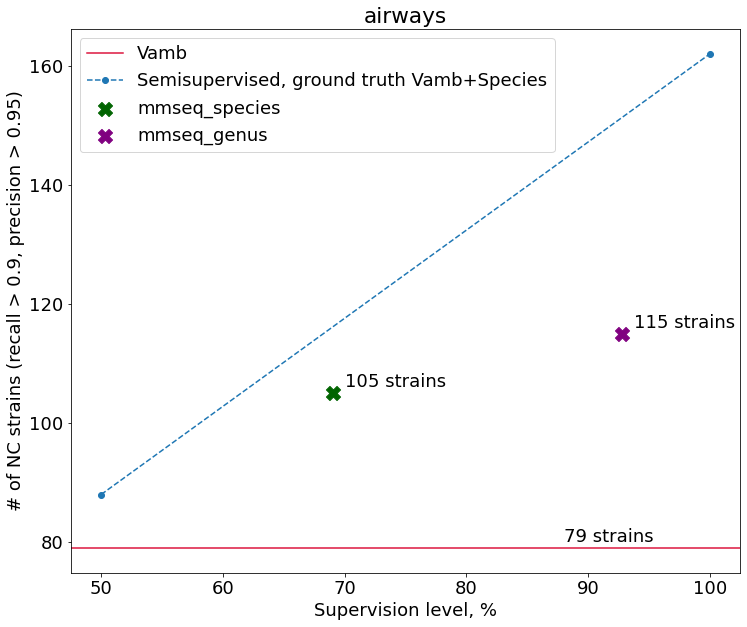

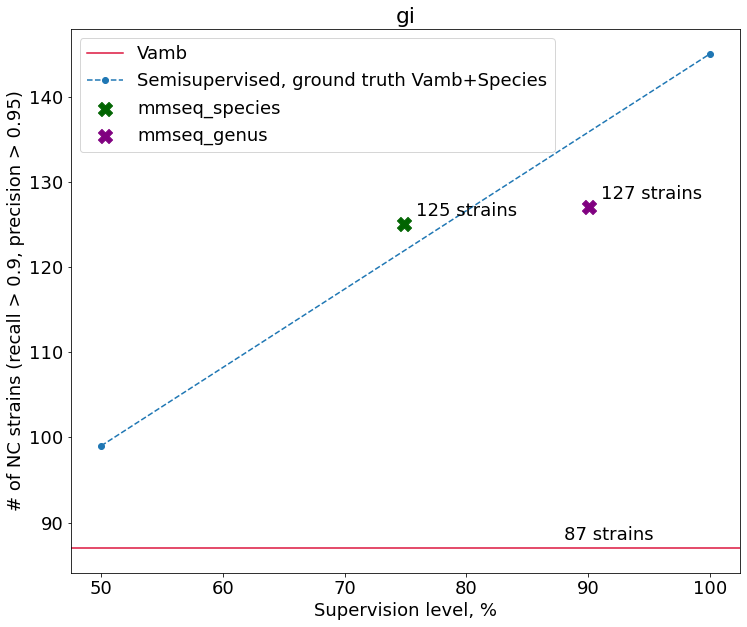

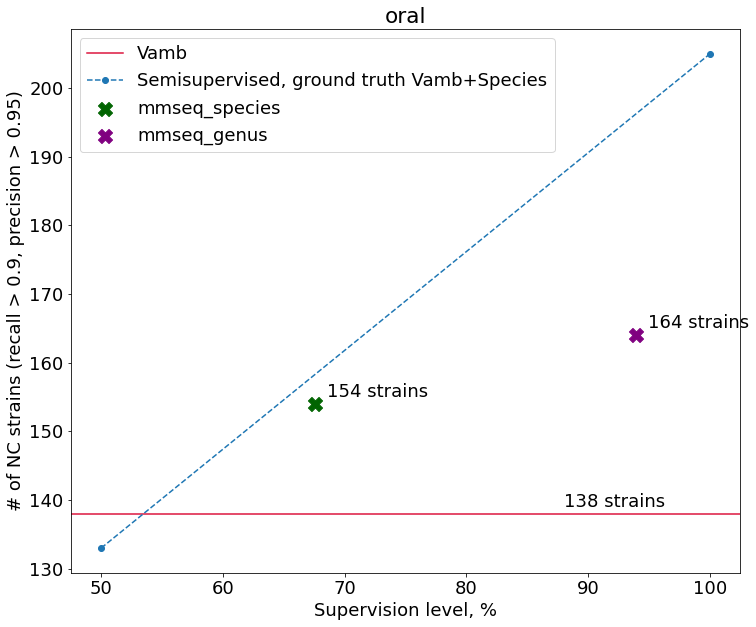

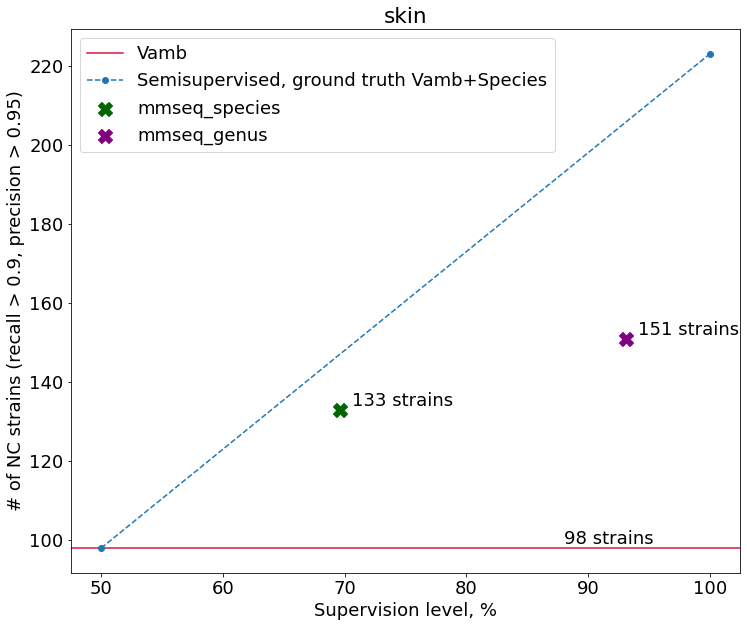

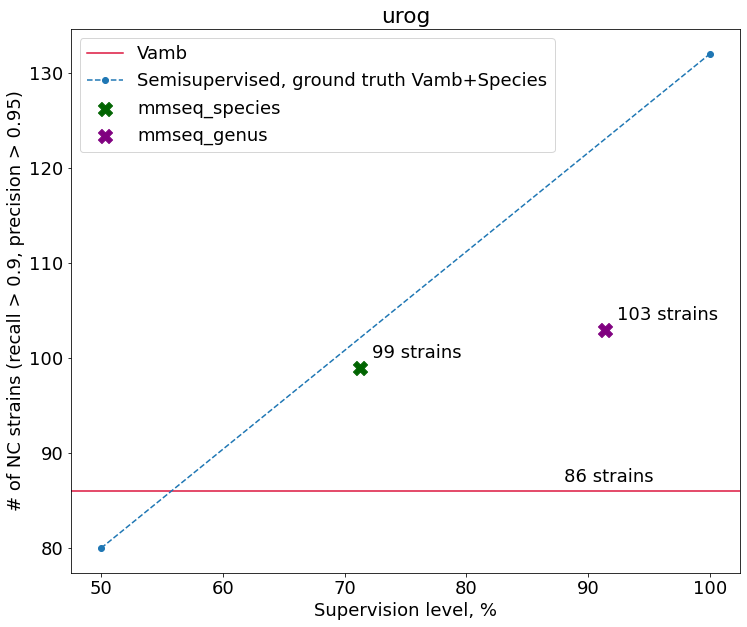

In [91]:
for s in ['airways', 'gi', 'oral', 'skin', 'urog']:
    plot_dataset(s)

In [87]:
for s in ['airways']:
    lat = np.load(f'{PATH_VAMB}/latent_trained_semisupervised_mmseq_vamb_{s}.npy')

    with open(f'{PATH_VAMB}/indices_mmseq_{s}.pickle', 'rb') as fp:
        indices_mmseq = pickle.load(fp)
    with open(f'{PATH_VAMB}/indices_mmseq_genus_{s}.pickle', 'rb') as fp:
        indices_mmseq_genus = pickle.load(fp)

    save_clusters_both(
        f'latent_trained_semisupervised_mmseq_vamb_{s}.npy',
        f'latent_trained_semisupervised_mmseq_both_{s}.npy',
        np.array(range(lat.shape[0])),
        np.array(indices_mmseq),
        f'clusters_mmseq_{s}.tsv',
        s,
    )

    save_clusters_both(
        f'latent_trained_semisupervised_mmseq_genus_vamb_{s}.npy',
        f'latent_trained_semisupervised_mmseq_genus_both_{s}.npy',
        np.array(range(lat.shape[0])),
        np.array(indices_mmseq_genus),
        f'clusters_mmseq_genus_{s}.tsv',
        s,
    )
    
    bins = bin_saved_clusters(f'{PATH_VAMB}/clusters_{s}.tsv', s)
    bins_species = bin_saved_clusters(f'{PATH_VAMB}/clusters_mmseq_{s}.tsv', s)
    bins_genus = bin_saved_clusters(f'{PATH_VAMB}/clusters_mmseq_genus_{s}.tsv', s)

    print(
        s, 
        'species', len(np.array(indices_mmseq))*1.0/lat.shape[0],
        'genus', len(np.array(indices_mmseq_genus))*1.0/lat.shape[0],
        bins.counters[0][(0.9, 0.95)], 
        bins_species.counters[0][(0.9, 0.95)], 
        bins_genus.counters[0][(0.9, 0.95)],
    )

(129596, 32) 129596 (129596,)
First key: S4C262502 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 49118
Number of bins after splitting and filtering: 500
(174118, 32) 174118 (174118,)
First key: S4C262502 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 63350
Number of bins after splitting and filtering: 477
airways species 0.6904973759224232 genus 0.9277139888643205 79 105 115


In [61]:
for s in ['gi', 'oral', 'skin', 'urog']:
    lat = np.load(f'{PATH_VAMB}/latent_trained_semisupervised_mmseq_vamb_{s}.npy')

    with open(f'{PATH_VAMB}/indices_mmseq_{s}.pickle', 'rb') as fp:
        indices_mmseq = pickle.load(fp)
    with open(f'{PATH_VAMB}/indices_mmseq_genus_{s}.pickle', 'rb') as fp:
        indices_mmseq_genus = pickle.load(fp)

    save_clusters_both(
        f'latent_trained_semisupervised_mmseq_vamb_{s}.npy',
        f'latent_trained_semisupervised_mmseq_both_{s}.npy',
        np.array(range(lat.shape[0])),
        np.array(indices_mmseq),
        f'clusters_mmseq_{s}.tsv',
        s,
    )

    bins = bin_saved_clusters(f'{PATH_VAMB}/clusters_{s}.tsv', s)
    bins_species = bin_saved_clusters(f'{PATH_VAMB}/clusters_mmseq_{s}.tsv', s)
    bins_genus = bin_saved_clusters(f'{PATH_VAMB}/clusters_mmseq_genus_{s}.tsv', s)

    print(
        s, 
        'species', len(np.array(indices_mmseq))*1.0/lat.shape[0],
        'genus', len(np.array(indices_mmseq_genus))*1.0/lat.shape[0],
        bins.counters[0][(0.9, 0.95)], 
        bins_species.counters[0][(0.9, 0.95)], 
        bins_genus.counters[0][(0.9, 0.95)],
    )

(61097, 32) 61097 (61097,)
First key: S5C311 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S3C1467 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 6087
Number of bins after splitting and filtering: 405
gi species 0.7487193941324968 genus 0.9004313619764222 87 125 127
(136223, 32) 136223 (136223,)
First key: S15C96626 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S15C106054 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 41413
Number of bins after splitting and filtering: 738
oral species 0.6758333622738301 genus 0.9393787550294449 138 154 164
(121133, 32) 121133 (121133,)
First key: S20C165151 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S20C165151 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 28984
Number of bins after splitting and filtering: 582
skin species 0.6964588591765

In [27]:
save_clusters_one('latent_trained_vamb_skin.npy', 'clusters_skin.tsv', 'skin')
vamb_gi = bin_saved_clusters('clusters_skin.tsv', 'skin')
vamb_gi.counters[0][(0.9, 0.95)]

latent_trained_vamb_skin.npy
(173927, 32)
First key: S20C90161 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S20C90161 of type: <class 'str'>
Number of bins before splitting and filtering: 49002
Number of bins after splitting and filtering: 543


98

In [29]:
save_clusters_one('latent_trained_vamb_airways.npy', 'clusters_airways.tsv', 'airways')
vamb_gi = bin_saved_clusters('clusters_airways.tsv', 'airways')
vamb_gi.counters[0][(0.9, 0.95)]

latent_trained_vamb_urog.npy
(57762, 32)
First key: S2C8931 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S2C16799 of type: <class 'str'>
Number of bins before splitting and filtering: 17424
Number of bins after splitting and filtering: 326


86